# Lesson3 系列データで分類・予測させてみよう（RNN, LSTM）

## 目次

- 3.4の解答
- Section4 実装②
    - 4.0 データの用意
    - 4.1 モデル構築
    - 4.2 モデルの学習
    - 4.3 モデルによる予測
    - 4.4 モデルの可視化

## Section3 Checkクイズの解答

問題1: 2, 問題2: 3, 問題3: 1, 問題4: 4

## Section4 実装②

ここでは、1949年1月から1960年12月までの月次航空会社乗客数のデータをLSTMで学習し、予測を行ってみましょう。

データは次のリンクのページのものを用います。

https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

このデータセットには、1列目に年月、2列目にその月の航空会社乗客数が千人単位で記録されています。

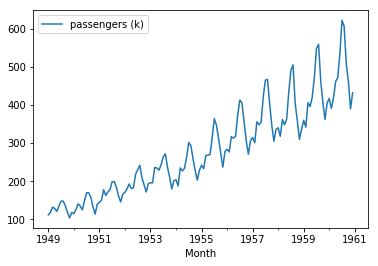

In [1]:
# データセット表示用コード
%matplotlib inline

import pandas as pd

dataframe = pd.read_csv('/root/userspace/public/lesson3/data/international-airline-passengers.csv', index_col=0, engine='python', skipfooter=3)
dataframe.columns = ['passengers (k)']
dataframe.index = pd.to_datetime(dataframe.index)
dataframe.plot()

### 4.0 データの用意

まずはデータを読み込みましょう。今回は2列目の乗客数のみ読み込みます。

なお、データがcsv形式なのでpandas.read_csvを用いてロードを行います。

In [1]:
%matplotlib inline

import pandas as pd

# データの読み込み（データセット中のYのみロード）
dataframe = pd.read_csv('/root/userspace/public/lesson3/data/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values.astype('float32')

データが人数という単位を持っているので、この単位への依存性をなくすため（また予測性能向上のため）スケーリングを行います。

なお、スケーリングには、ライブラリscikit-learnの`MinMaxScaler`クラスを使用します。

`MinMaxScaler`は初期化時に`feature_range`引数として、どの範囲にスケーリングするかを指定すると、

`fit_trasform`メソッドでデータセットをスケーリングし、またスケーリングに用いたパラメータを記憶します。

そのため逆変換も可能で、`inverse_transform`メソッドを用いれば、データのスケーリングを元に戻すことができます。（後ほど結果の処理で使用）

In [2]:
dataset[0]

array([ 112.], dtype=float32)

In [3]:
from sklearn.preprocessing import MinMaxScaler

# [0,1]に正規化
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

続いて、データセットを訓練用とテスト用に分割します。時系列の予測が目的のため、ある時点を境に訓練用、テスト用と分割します。

In [4]:
dataset[0]

array([ 0.01544401], dtype=float32)

In [4]:
# 訓練データとテストデータを分割（時系列の予測が目的のため、ある時点から先をテストデータとする）
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

時系列の予測の場合、ある時点のデータのみ参照して同じ時点の予測を行うことは困難です。

そこで、数回前のデータまで参照できるようにしましょう。RNNでは、この数回前までのデータを1系列とみなして入力に使用します。

In [5]:
import numpy as np

# X=[data[t-look_back],...,data[t-1]], Y=data[t]となるデータセットに変換
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# [samples, time steps, features]へ変形
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

### 4.1 モデル構築

ここでは、先程紹介したLSTM（4ユニット）を使用してモデルを構築します。

また、最終的に必要な出力はスカラー値なので、最後にDenseレイヤーを使用し、損失関数はMSEを用います。

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM

# LSTMにDenseを接続し、数値を予測（MSEで評価）
model = Sequential()

model.add(LSTM(4, input_shape=(look_back, 1))) # input_shape=(系列長T, x_tの次元), output_shape=(系列長T, units)
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

Using TensorFlow backend.


### 4.2 モデルの学習

In [7]:
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 2s - loss: 0.0362
Epoch 2/100
 - 1s - loss: 0.0140
Epoch 3/100
 - 1s - loss: 0.0111
Epoch 4/100
 - 1s - loss: 0.0099
Epoch 5/100
 - 1s - loss: 0.0087
Epoch 6/100
 - 1s - loss: 0.0076
Epoch 7/100
 - 1s - loss: 0.0068
Epoch 8/100
 - 1s - loss: 0.0061
Epoch 9/100
 - 1s - loss: 0.0053
Epoch 10/100
 - 1s - loss: 0.0048
Epoch 11/100
 - 1s - loss: 0.0046
Epoch 12/100
 - 1s - loss: 0.0044
Epoch 13/100
 - 1s - loss: 0.0042
Epoch 14/100
 - 1s - loss: 0.0043
Epoch 15/100
 - 1s - loss: 0.0041
Epoch 16/100
 - 1s - loss: 0.0040
Epoch 17/100
 - 1s - loss: 0.0040
Epoch 18/100
 - 1s - loss: 0.0039
Epoch 19/100
 - 1s - loss: 0.0039
Epoch 20/100
 - 1s - loss: 0.0040
Epoch 21/100
 - 1s - loss: 0.0039
Epoch 22/100
 - 1s - loss: 0.0040
Epoch 23/100
 - 1s - loss: 0.0038
Epoch 24/100
 - 1s - loss: 0.0037
Epoch 25/100
 - 1s - loss: 0.0040
Epoch 26/100
 - 1s - loss: 0.0038
Epoch 27/100
 - 1s - loss: 0.0038
Epoch 28/100
 - 1s - loss: 0.0037
Epoch 29/100
 - 1s - loss: 0.0038
Epoch 30/100
 - 1s - lo

### 4.3 モデルによる予測

予測の精度をRMSEで評価してみましょう。ここではイメージが湧くように、正規化を解いて人数の単位で出力しています。

In [8]:
import math
from sklearn.metrics import mean_squared_error

# テストデータに対する予測（評価のため訓練データも）
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 正規化を元に戻す
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# 平均二乗誤差のルートで評価
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Train RMSE: 24.51
Test RMSE: 70.11


最後に、予測データのプロットを行って視覚的に評価を行いましょう。

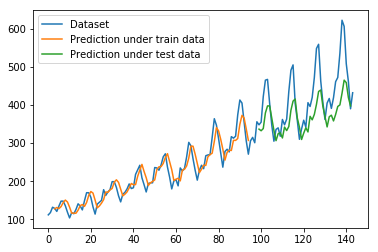

In [9]:
import matplotlib.pyplot as plt

# 訓練データ部分の予測データ
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# テストデータ部分の予測データ
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset), label='Dataset')
plt.plot(trainPredictPlot, label='Prediction under train data')
plt.plot(testPredictPlot, label='Prediction under test data')
plt.legend()
plt.show()

### 4.4 モデルの可視化

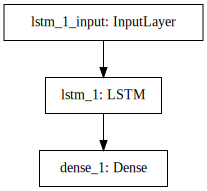

In [10]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))